In [1]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon
from pathlib import Path

In [2]:
#Define the size of the card in milimeters
cardW=57
cardH=87
cornerXmin=2
cornerXmax=10.5
cornerYmin=2.5
cornerYmax=23

#Apply an aribtary increase (4) to the size of the card and covert mm into pixels
zoom=4
cardW*=zoom
cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

In [3]:
data_dir="data"

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

card_suits=['S','H','D','C']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"/cards.pck"

# imgW,imgH: dimensions of the generated dataset images 
imgW=720
imgH=720

refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])

# Load in background images

In [4]:
run_cell = 0
if run_cell == 1:
    #Download the textures dataset
    !wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

    #Extract the dataset
    !tar xf dtd-r1.0.1.tar.gz

    #Save all background images into a background directory and pickle the file
    dtd_dir="dtd/images/"
    bg_images=[]
    for subdir in glob(dtd_dir+"/*"):
        for f in glob(subdir+"/*.jpg"):
            bg_images.append(mpimg.imread(f))
    print("Nb of images loaded :",len(bg_images))
    print("Saved in :",backgrounds_pck_fn)
    pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))

In [5]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()


Nb of images loaded : 5640


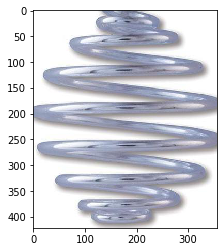

In [6]:
# Test: display a random background
_=backgrounds.get_random(display=True)

# Extraction of the cards from pictures or video 

### Define the alphamask
The alphamask has 2 purposes:
- clean the border of the detected cards,
- make that border transparent. Cards are not perfect rectangles because corners are rounded. We need to make transparent the zone between the real card and its bounding rectangle, otherwise this zone will be visible in the final generated images of the dataset


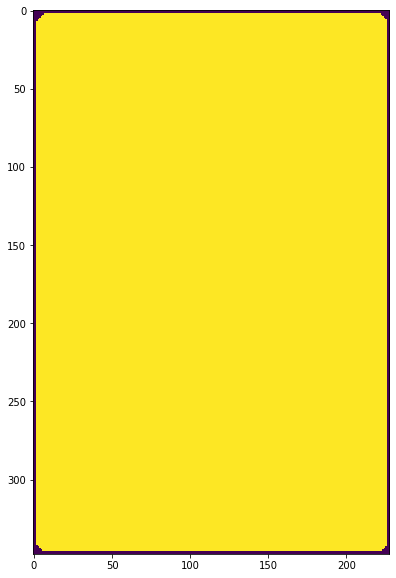

In [7]:
bord_size=2
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

In [8]:

def extract_card (img, output_fn=None, min_focus=120):
    imgwarp=None        
    # Convert in gray color
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Noise-reducing and edge-preserving filter
    gray=cv2.bilateralFilter(gray,11,17,17)    
    # Edge extraction
    edge=cv2.Canny(gray,30,200)    
    # Find the contours in the edged image
    cnts, _ = cv2.findContours(edge.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    
    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect=cv2.minAreaRect(cnt)
    box=cv2.boxPoints(rect)
    box=np.int0(box)
    areaCnt=cv2.contourArea(cnt)
    areaBox=cv2.contourArea(box)
    valid=areaCnt/areaBox>0.95
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)
        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnt.reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(np.int)
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)
        
        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)
        
        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel
        
        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)
        
    return valid,imgwarp

In [9]:
imgs_dir="data/cards"

cards={}
for suit in card_suits:
    for value in card_values:
        card_name=value+suit        
        card_dir=os.path.join(imgs_dir,card_name)

        
        if not os.path.isdir(card_dir):
            print(f"!!! {card_dir} does not exist !!!")
            continue
        cards[card_name]=[]
        for f in glob(card_dir+"/*.jpeg"):
            img=cv2.imread(f,cv2.IMREAD_UNCHANGED)
            
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
            cards[card_name].append((img))
        print(f"Nb images for {card_name} : {len(cards[card_name])}")



print("Saved in :",cards_pck_fn)
pickle.dump(cards,open(cards_pck_fn,'wb'))

cv2.destroyAllWindows()

Nb images for AS : 1
Nb images for KS : 1
Nb images for QS : 1
Nb images for JS : 1
Nb images for 10S : 1
Nb images for 9S : 1
Nb images for 8S : 1
Nb images for 7S : 1
Nb images for 6S : 1
Nb images for 5S : 1
Nb images for 4S : 1
Nb images for 3S : 1
Nb images for 2S : 1
Nb images for AH : 1
Nb images for KH : 1
Nb images for QH : 1
Nb images for JH : 1
Nb images for 10H : 1
Nb images for 9H : 1
Nb images for 8H : 1
Nb images for 7H : 1
Nb images for 6H : 1
Nb images for 5H : 1
Nb images for 4H : 1
Nb images for 3H : 1
Nb images for 2H : 1
Nb images for AD : 1
Nb images for KD : 1
Nb images for QD : 1
Nb images for JD : 1
Nb images for 10D : 1
Nb images for 9D : 1
Nb images for 8D : 1
Nb images for 7D : 1
Nb images for 6D : 1
Nb images for 5D : 1
Nb images for 4D : 1
Nb images for 3D : 1
Nb images for 2D : 1
Nb images for AC : 1
Nb images for KC : 1
Nb images for QC : 1
Nb images for JC : 1
Nb images for 10C : 1
Nb images for 9C : 1
Nb images for 8C : 1
Nb images for 7C : 1
Nb images

In [10]:
#Load in all of the cards
class Cards():
    def __init__(self,cards_pck_fn=cards_pck_fn):
        self._cards=pickle.load(open(cards_pck_fn,'rb'))
        # self._cards is a dictionary where keys are card names (ex:'Kc') and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        card=self._cards[card_name][random.randint(0,self._nb_cards_by_value[card_name]-1)]
        if display:
            if display: display_img(card,"rgb")
        return card,card_name

    
cards = Cards()


Nb of cards loaded per name : {'AS': 1, 'KS': 1, 'QS': 1, 'JS': 1, '10S': 1, '9S': 1, '8S': 1, '7S': 1, '6S': 1, '5S': 1, '4S': 1, '3S': 1, '2S': 1, 'AH': 1, 'KH': 1, 'QH': 1, 'JH': 1, '10H': 1, '9H': 1, '8H': 1, '7H': 1, '6H': 1, '5H': 1, '4H': 1, '3H': 1, '2H': 1, 'AD': 1, 'KD': 1, 'QD': 1, 'JD': 1, '10D': 1, '9D': 1, '8D': 1, '7D': 1, '6D': 1, '5D': 1, '4D': 1, '3D': 1, '2D': 1, 'AC': 1, 'KC': 1, 'QC': 1, 'JC': 1, '10C': 1, '9C': 1, '8C': 1, '7C': 1, '6C': 1, '5C': 1, '4C': 1, '3C': 1, '2C': 1}


In [11]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)
        


In [12]:
def give_me_filename(dirname, suffixes, prefix=""):
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames

In [13]:

decalX=int((imgW-cardW)/2)
decalY=int((imgH-cardH)/2) 

cardKP = ia.KeypointsOnImage([
    ia.Keypoint(x=decalX,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY),   
    ia.Keypoint(x=decalX+cardW,y=decalY+cardH),
    ia.Keypoint(x=decalX,y=decalY+cardH)
    ], shape=(imgH,imgW,3))

transform_1card = iaa.Sequential([
    #Set the scale percentage of the original image
    iaa.Affine(scale=[0.40,0.55]), #was 0.65, 1
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}), #was -0.25,0.25
])

trans_rot1 = iaa.Sequential([
    iaa.Affine(translate_px={"x": (10, 20)}), #was 10,20
    iaa.Affine(rotate=(22,30))
])


scaleBg=iaa.Scale({"height": imgH, "width": imgW})

def augment(img, list_kps, seq, restart=True):
    while True:
        if restart:
            myseq=seq.to_deterministic()
        else:
            myseq=seq
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        valid=True
        if valid: break
        elif not restart:
            img_aug=None
            break                
    return img_aug,list_kps_aug

class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):   
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname

class Scene:
    def __init__(self,bg,img1, class1):

        self.createCardScene(bg,img1, class1)

    def createCardScene(self,bg,img1, class1):
        self.img1=np.zeros((imgH,imgW,4),dtype=np.uint8)       
        self.img1[decalY:decalY+cardH,decalX:decalX+cardW,:]=img1
        self.img1,self.lkps1=augment(self.img1,[cardKP],transform_1card)
        
        self.class1=class1
            
        self.bg=scaleBg.augment_image(bg)
        mask1=self.img1[:,:,3]
        self.mask1=np.stack([mask1]*3,-1)       
        
        
        self.y_min = np.min(np.unique(np.where(self.mask1)[1]))
        self.y_max = np.max(np.unique(np.where(self.mask1)[1]))

        self.x_min = np.min(np.unique(np.where(self.mask1)[0]))
        self.x_max = np.max(np.unique(np.where(self.mask1)[0]))
        
        self.final=np.where(self.mask1,self.img1[:,:,0:3],self.bg)
                        
    
    def display(self):
        return(self.final, self.y_min, self.y_max, self.x_min, self.x_max, self.class1)
        


/Users/oly/anaconda3/lib/python3.7/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


In [14]:
def create_the_files(save_dir, img, x_min, y_min, x_max, y_max, class1):
    jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
    plt.imsave(jpg_fn, img)
    
    with open(xml_fn,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(jpg_fn), 'PATH':jpg_fn,'WIDTH':img.shape[0],'HEIGHT':img.shape[1]}))
        for i in range(0,1):
            f.write(xml_object.format(**{'CLASS':class1,'XMIN':x_min,'YMIN':y_min,'XMAX':x_max,'YMAX':y_max}))
        f.write(xml_body_2)
        
        
def create_the_files_no_xml(save_dir, img, x_min, y_min, x_max, y_max, class1):
    jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
    plt.imsave(jpg_fn, img)

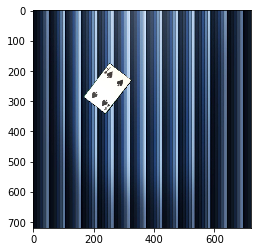

In [15]:
bg=backgrounds.get_random()
img1,card_val1=cards.get_random()
img2,card_val2=cards.get_random()

newimg=Scene(bg,img1,card_val1)
#x, y, m1, img1, bg = newimg.display()
img, y_min, y_max, x_min, x_max, class1 = newimg.display()

plt.imshow(img)

In [17]:

#Create a dictionary to turn cards into specific card values

card_suits=['S','H','D','C']
card_values=['A','K','Q','J','10','9','8','7','6','5','4','3','2']

all_card_values = []

for v in card_values:
    for s in card_suits:
        all_card_values.append(v+s)
        
card_vals_dict = {}

for i in all_card_values:
    if len(i) > 2:
        val = i[0:2]
    else: val = i[0]
    card_vals_dict[i] = val


# Create images for output

Images that will be used for training

In [18]:
train_images = 1 #Amount of images to create per class
test_images = 1 #amount of images to create per class
train_dir = 'Images/train_test'
test_dir = 'Images/test_test'

In [19]:
for x in all_card_values:
    for i in range(train_images):
        bg=backgrounds.get_random()
        img1,card_val1=cards.get_random(card_name=x)
        newimg=Scene(bg,img1,card_val1)
        img, y_min, y_max, x_min, x_max, class1 = newimg.display()
        class1 = card_vals_dict[class1] #forces the class to be just the card value. Comment out for 52 classes
        create_the_files(train_dir, img, x_min, y_min, x_max, y_max, class1)
print('Testing Images Created')


for x in all_card_values:
    for i in range(test_images):
        bg=backgrounds.get_random()
        img1,card_val1=cards.get_random(card_name=x)
        newimg=Scene(bg,img1,card_val1)
        img, y_min, y_max, x_min, x_max, class1 = newimg.display()
        class1 = card_vals_dict[class1] #forces the class to be just the card value. Comment out for 52 classes
        create_the_files(test_dir, img, x_min, y_min, x_max, y_max, class1)

print('Testing Images Created')

Testing Images Created
Testing Images Created


Craete Images for Validation

In [20]:
validation_images = 1 #Amount of images to create per class
validation_dir = 'Images/validation_test'

In [21]:
#Create the folder structure for each of the classes if it does not exist
for i in all_card_values:
    x = card_vals_dict[i] #Forces to be only card values not suit and values
    Path(validation_dir+"/"+x).mkdir(parents=True, exist_ok=True)

In [23]:
for x in all_card_values:
    for i in range(validation_images):      
        bg=backgrounds.get_random()
        img1,card_val1=cards.get_random(card_name=x)

        newimg=Scene(bg,img1,card_val1)
        img, y_min, y_max, x_min, x_max, class1 = newimg.display()
        class1 = card_vals_dict[class1]
        
        save_dir = validation_dir+"/"+class1 
        
        #Do not create an xml file but save just the image
        create_the_files_no_xml(save_dir, img, x_min, y_min, x_max, y_max, class1)

print('Validation Images Created')

Validation Images Created
